<a href="https://colab.research.google.com/github/camilorey/material_clases/blob/main/graficas_utiles_para_analizar_un_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#librería para conectarse a la base de datos
import numpy as NumPy
import psycopg2 as Psycopg2
#librería para contener datos
import pandas as Pandas #el DataFrame que contendrá los datos
#librerías para graficar datos
import seaborn as SeaBorn #para poder hacer gráficas
import matplotlib.pyplot as PyPlot #para ayudar al hacer gráficas

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Conectándose a una Base de Datos Pública

Vamos a extraer los datos de una Base de Datos Pública que he montado y obtener los datos a partir de queries en un lenguaje llamado SQL.

Lo primero que necesitamos son las credenciales de acceso a la Base de Datos

In [ ]:
#credenciales de la Base de Datos Elephant del banco Class-A
servidor_db = 'lallah.db.elephantsql.com'
nombre_db = 'jjcltkov'
usuario_db = 'jjcltkov'
password_db = 'xL1IczpM2h36TbBbVz7dpIhgL8SgsWxI'

y vamos a usar un método que dada una búsqueda dentro de la base de datos, retorna el resultado como un Pandas DataFrame. 

In [ ]:
def busquedaComoDataFrame(queryBusqueda):
  conexionDB = None
  resultado = None #dataframe que contendrá el resultado de la búsqueda
  try:
    #vamos a hacer la conexión a la base de datos (Esta instrucción siempre es igual)
    conexionDB = Psycopg2.connect(host=servidor_db,database=nombre_db,user=usuario_db,password=password_db)
    #vamos a confirmar que estamos conectados a la base de datos
    print("conexión establecida con la base de datos")
    #vamos a ejecutar el comando y meterlo de una dentro del DataFrame
    resultado = Pandas.read_sql_query(queryBusqueda,conexionDB)
    print("resultado obtenido, todo bien")
    #ahora cerramos la conexión
    conexionDB.close()
  except (Exception,Psycopg2.DatabaseError) as Error:
    print("Ha ocurrido un error")
    print(Error)
  finally:
    if conexionDB is not None:
      conexionDB.close()
  #sea como sea el ingreso a la DB fue hecho, necesitamos retornar el resultado
  return resultado

#Extrayendo los datos de los clientes desde la base de datos

Ahora, por medio de Queries en SQL podemos obtener la información de la base de datos, de forma estructurada (en un DataFrame). 

Esta es la base de datos de un banco, que contiene tanto la información de los clientes, cómo la información de las transacciones incurridas por los clientes dentro de él. 

Vamos a pedir la información de los clientes: su cédula, sexo, estrato y sexo. 

In [ ]:
query_clientes = """SELECT * FROM cliente"""

Usamos el método para retornar la información de los clientes como un DataFrame.

In [ ]:
info_clientes = busquedaComoDataFrame(query_clientes)

conexión establecida con la base de datos
resultado obtenido, todo bien


Ahora, extrajimos la información de los clientes desde la Base de Datos que podemos ver como un DataFrame. 

In [ ]:
info_clientes.head()

,cedula,estrato,sexo,saldo
0,80424658,2,MASCULINO,1268611.54
1,1001731662,2,MASCULINO,1069947.51
2,45491993,3,FEMENINO,2312620.21
3,45589984,2,FEMENINO,955885.25
4,45582082,3,FEMENINO,1711703.72


Podemos usar un bloque de código de SeaBorn para ver cómo se distribuyen las variables categóricas y las numéricas. 

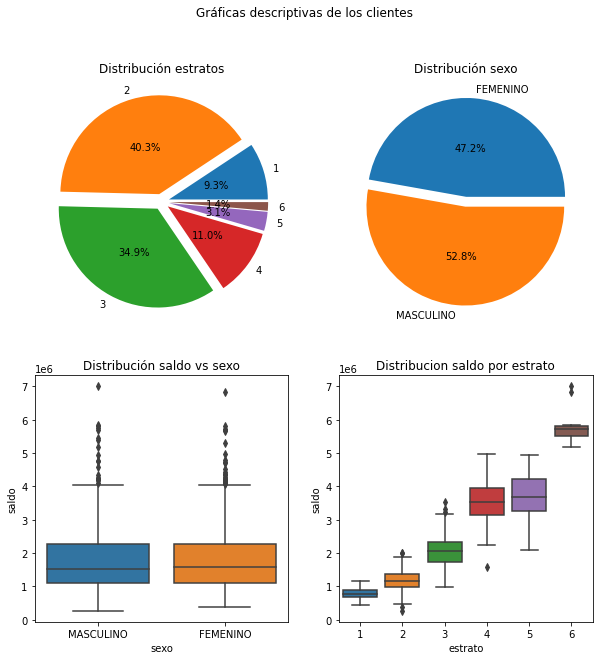

In [ ]:
figura, subFiguras = PyPlot.subplots(2,2, #vamos a poner un arreglo de 1x3 figuras
                                     figsize=(10,10)) #El tamaño va a ser de 12 x 3 unidades
#ponemos el título grande
figura.suptitle('Gráficas descriptivas de los clientes')
#ponemos los títulos de las subfiguras

subFiguras[0,0].set_title('Distribución estratos')
subFiguras[0,1].set_title('Distribución sexo')
subFiguras[1,0].set_title('Distribución saldo vs sexo')
subFiguras[1,1].set_title('Distribucion saldo por estrato')
info_estratos = info_clientes.groupby('estrato')['cedula'].count()
labels = info_estratos.keys()
subFiguras[0,0].pie(x=info_estratos, autopct="%.1f%%", explode=[0.08]*6, labels=labels, pctdistance=0.5)
info_sexo = info_clientes.groupby('sexo')['cedula'].count()
labels = info_sexo.keys()
subFiguras[0,1].pie(x=info_sexo, autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
SeaBorn.boxplot(data=info_clientes,
                    x='sexo',
                    y='saldo',
                    ax=subFiguras[1,0])
#cajas de bigotes para ver cómo se reparte el saldo en rojo dependiendo del estrato
SeaBorn.boxplot(data=info_clientes,
                x='estrato', #la variable categórica con la cual podemos separar datos
                y='saldo', #la variable sobre la cual queremos hacer cajas de bigotes
                ax=subFiguras[1,1]) #la locación donde lo quiero en la gran figura
figura.show()

Notemos que la variable categórica de sexo no es determinante por ejemplo para el saldo, mientras que la variable estrato es fundamental. Aquí es donde se ve la diferencia entre un estrato y otro. 

#Caracterizando el perfil transaccional de los clientes

Ahora, podemos pedir los datos de transacciones de los clientes dependiendo del estrato, usando búsquedas específicas. 

Vamos a solicitar una serie de tiempo de los clientes de un estrato, como un DataFrame que contendra:
* La fecha
* El número de transacciones efectuado
* El volúmen transado en ese día

Este DataFrame separará las transacciones por tipo (INGRESO o EGRESO) y además por estrato. Para cubrir todos los estratos deberemos buscar en la base de datos una y otra vez para obtener DataFrames por transacción y por estrato.

In [ ]:
def queryTransaccionesPorEstrato(numEstrato,tipoTransaccion):
  return """SELECT DATE(transaccion.fecha) AS "fecha", 
            COUNT(transaccion.cedula) AS "num_transacciones",
            SUM(transaccion.monto) AS "vol_transacciones"
            FROM transaccion JOIN cliente ON transaccion.cedula = cliente.cedula
                             JOIN tipoTransaccion ON transaccion.tipoTransaccion_id = tipoTransaccion.tipoTransaccion_id
            WHERE cliente.estrato ="""+str(numEstrato)+""" AND tipoTransaccion.tipoTransaccion = '"""+tipoTransaccion+"""'
            GROUP BY fecha
            ORDER BY fecha;"""


El siguiente bloque de código extraerá de la base de datos la información de los clientes de los estratos por número y los convertirá en Series de tiempo. 

In [ ]:
def infoTransaccionesEstrato(numEstrato):
  info_ingresos=busquedaComoDataFrame(queryTransaccionesPorEstrato(numEstrato,'INGRESO'))
  info_ingresos['fecha'] = Pandas.to_datetime(info_ingresos['fecha'])
  info_ingresos = info_ingresos.set_index('fecha')
  info_egresos = busquedaComoDataFrame(queryTransaccionesPorEstrato(numEstrato,'EGRESO'))
  info_egresos['fecha'] = Pandas.to_datetime(info_egresos['fecha'])
  info_egresos = info_egresos.set_index('fecha')
  return info_ingresos,info_egresos

Con el método aquí arriba podemos automatizar y generar varios dataframes que contengan la información transaccional de cada uno de los estratos que la guardaremos en lo que Python llama un Diccionario (un arreglo asociativo con claves en texto). 

In [ ]:
estratos = []
info_estratos ={}
for i in range(1,7):
  nomEstrato = 'Estrato '+str(i)
  print('obteniendo información de estrato', nomEstrato)
  info_ingresos_estrato,info_egresos_estrato = infoTransaccionesEstrato(i)
  info_estratos[nomEstrato] = {'ingresos':info_ingresos_estrato,
                                      'egresos':info_egresos_estrato}
  estratos.append(nomEstrato)


obteniendo información de estrato Estrato 1
conexión establecida con la base de datos
resultado obtenido, todo bien
conexión establecida con la base de datos
resultado obtenido, todo bien
obteniendo información de estrato Estrato 2
conexión establecida con la base de datos
resultado obtenido, todo bien
conexión establecida con la base de datos
resultado obtenido, todo bien
obteniendo información de estrato Estrato 3
conexión establecida con la base de datos
resultado obtenido, todo bien
conexión establecida con la base de datos
resultado obtenido, todo bien
obteniendo información de estrato Estrato 4
conexión establecida con la base de datos
resultado obtenido, todo bien
conexión establecida con la base de datos
resultado obtenido, todo bien
obteniendo información de estrato Estrato 5
conexión establecida con la base de datos
resultado obtenido, todo bien
conexión establecida con la base de datos
resultado obtenido, todo bien
obteniendo información de estrato Estrato 6
conexión estable

Podemos sacar gráficos para cada uno de los estratos con el siguiente bloque de código. 

In [ ]:
def graficosTransaccionesPorEstrato(nomEstrato):
  info_ingresos = info_estratos[nomEstrato]['ingresos']
  info_egresos = info_estratos[nomEstrato]['egresos']
  figura, subFiguras = PyPlot.subplots(2,2, #vamos a poner un arreglo de 1x2 figuras
                                     figsize=(25,10)) #El tamaño va a ser de 12 x 3 unidades
  
  #ponemos el título grande
  figura.suptitle('Series de tiempo banco Class-A para '+nomEstrato)
  #ponemos los títulos para cada figura
  subFiguras[0,1].set_title('Número de transacciones '+nomEstrato)
  subFiguras[1,0].set_title('Volúmen de transacciones'+nomEstrato)
  SeaBorn.histplot(info_ingresos,x='num_transacciones',ax=subFiguras[0,0],color='blue',kde=True)
  SeaBorn.histplot(info_egresos,x='num_transacciones',ax=subFiguras[1,1],color='red',kde=True)
  #graficamos los datos de ingresos
  SeaBorn.lineplot(data=info_ingresos['num_transacciones'],marker='o',ax=subFiguras[0,1],color='blue')
  SeaBorn.lineplot(data=info_ingresos['vol_transacciones'],marker='o',ax=subFiguras[1,0],color='blue')
  #graficamos los datos de egreso
  SeaBorn.lineplot(data=info_egresos['num_transacciones'],marker='o',ax=subFiguras[0,1],color='red')
  SeaBorn.lineplot(data=info_egresos['vol_transacciones'],marker='o',ax=subFiguras[1,0],color='red')
  PyPlot.show()

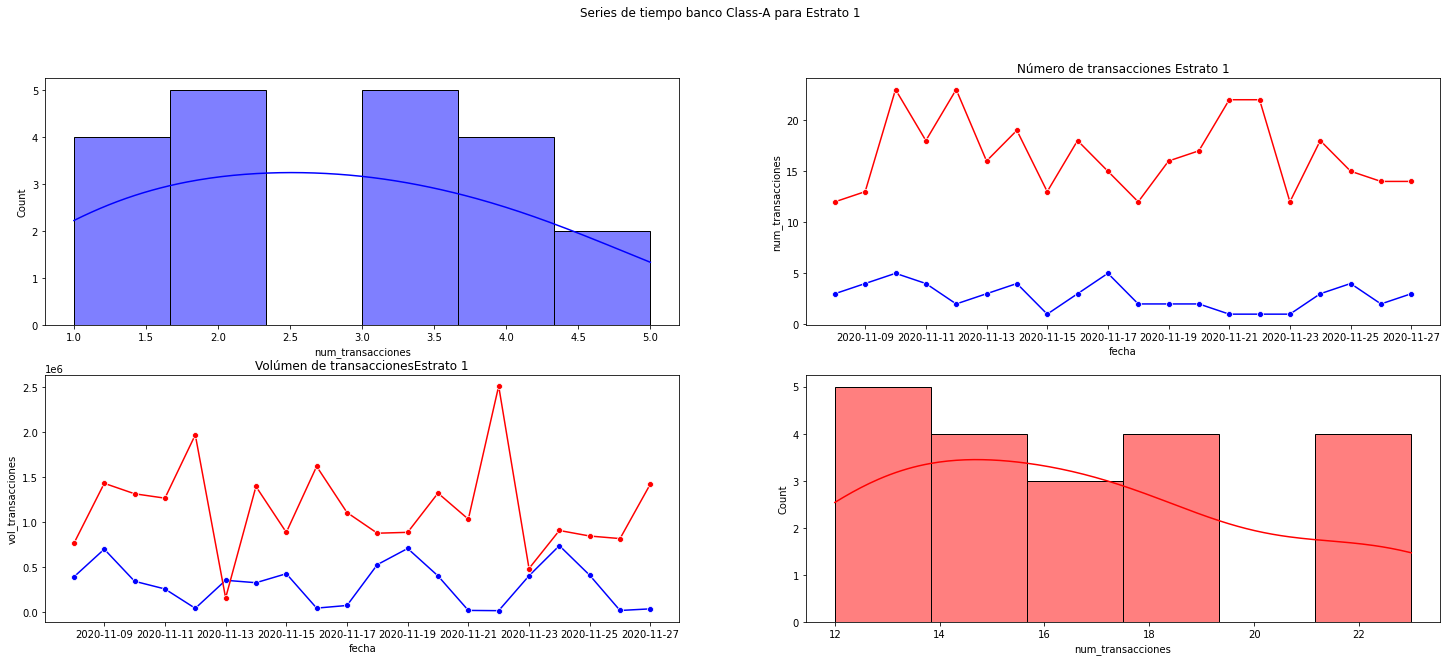

In [ ]:
graficosTransaccionesPorEstrato('Estrato 1')

Además, al tener la información de todos los estratos, podemos sacar gráficos para todos los estratos de la información recabada.

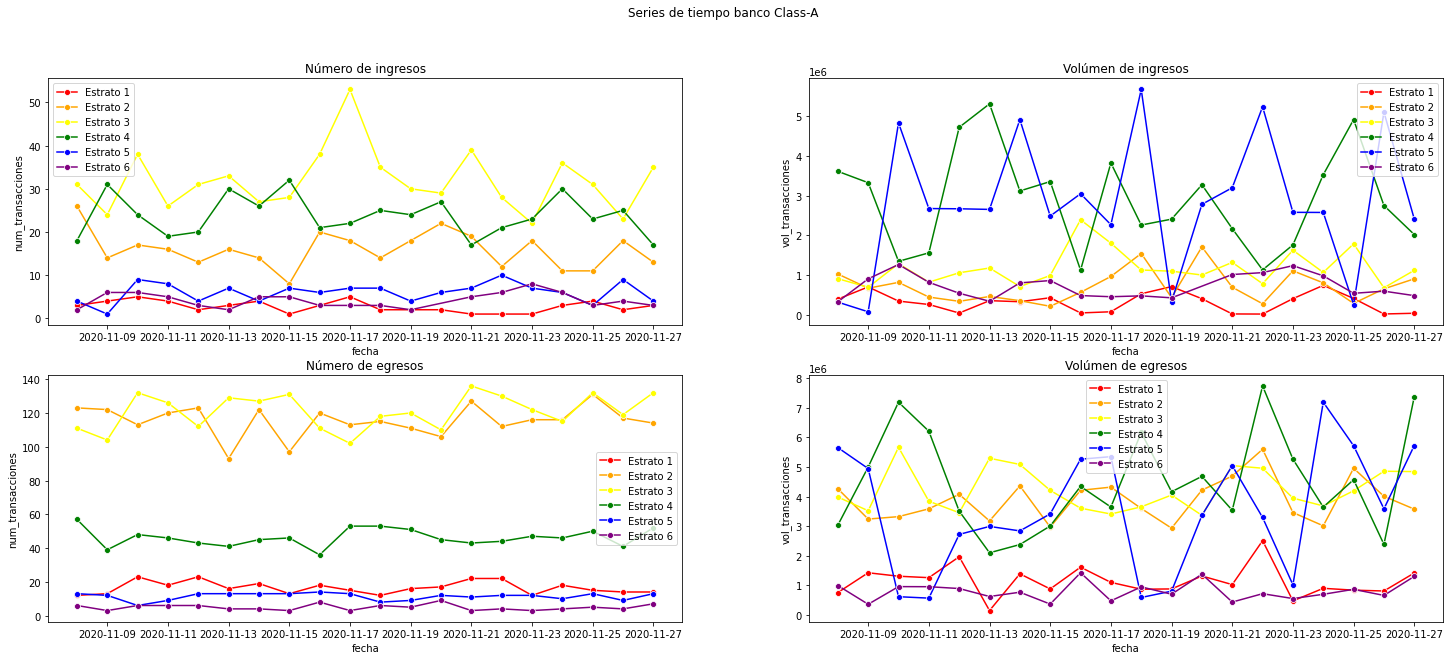

In [ ]:
figura, subFiguras = PyPlot.subplots(2,2, #vamos a poner un arreglo de 1x2 figuras
                                     figsize=(25,10)) #El tamaño va a ser de 12 x 3 unidades
colores ={'Estrato 1':'red',
          'Estrato 2':'orange',
          'Estrato 3':'yellow',
          'Estrato 4':'green',
          'Estrato 5':'blue',
          'Estrato 6':'purple'}
#ponemos el título grande
figura.suptitle('Series de tiempo banco Class-A')
#ponemos los títulos para cada figura
subFiguras[0,0].set_title('Número de ingresos')
subFiguras[1,0].set_title('Número de egresos')
subFiguras[0,1].set_title('Volúmen de ingresos')
subFiguras[1,1].set_title('Volúmen de egresos')
for i in range(0,len(estratos)):
  info_ingresos = info_estratos[estratos[i]]['ingresos']
  info_egresos = info_estratos[estratos[i]]['egresos']
  SeaBorn.lineplot(data=info_ingresos['num_transacciones'],marker='o',ax=subFiguras[0,0],label=estratos[i],color=colores[estratos[i]])
  SeaBorn.lineplot(data=info_egresos['num_transacciones'],marker='o',ax=subFiguras[1,0],label=estratos[i],color=colores[estratos[i]])
  SeaBorn.lineplot(data=info_ingresos['vol_transacciones'],marker='o',ax=subFiguras[0,1],label=estratos[i],color=colores[estratos[i]])
  SeaBorn.lineplot(data=info_egresos['vol_transacciones'],marker='o',ax=subFiguras[1,1],label=estratos[i],color=colores[estratos[i]])
PyPlot.show()

Ahora, veámoslo en cuestión de distribuciones:

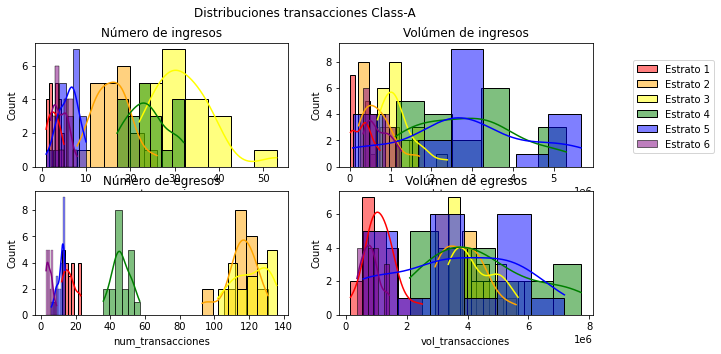

In [ ]:
figura, subFiguras = PyPlot.subplots(2,2, #vamos a poner un arreglo de 1x2 figuras
                                     figsize=(10,5)) #El tamaño va a ser de 12 x 3 unidades
colores ={'Estrato 1':'red',
          'Estrato 2':'orange',
          'Estrato 3':'yellow',
          'Estrato 4':'green',
          'Estrato 5':'blue',
          'Estrato 6':'purple'}
#ponemos el título grande
figura.suptitle('Distribuciones transacciones Class-A')
#ponemos los títulos para cada figura
subFiguras[0,0].set_title('Número de ingresos')
subFiguras[1,0].set_title('Número de egresos')
subFiguras[0,1].set_title('Volúmen de ingresos')
subFiguras[1,1].set_title('Volúmen de egresos')
for i in range(0,len(estratos)):
  info_ingresos = info_estratos[estratos[i]]['ingresos']
  info_egresos = info_estratos[estratos[i]]['egresos']
  SeaBorn.histplot(info_ingresos,x='num_transacciones',ax=subFiguras[0,0],kde=True,label=estratos[i],color=colores[estratos[i]])
  SeaBorn.histplot(info_egresos,x='num_transacciones',ax=subFiguras[1,0],kde=True,label=estratos[i],color=colores[estratos[i]])
  SeaBorn.histplot(info_ingresos,x='vol_transacciones',ax=subFiguras[0,1],kde=True,label=estratos[i],color=colores[estratos[i]])
  SeaBorn.histplot(info_egresos,x='vol_transacciones',ax=subFiguras[1,1],kde=True,label=estratos[i],color=colores[estratos[i]])
PyPlot.legend(bbox_to_anchor=(1.5, 2.1), loc='upper right')
PyPlot.show()

Podemos ver el comportamiento de volúmen de transacciones vs número de transacciones hechas usando scatter plots. Dividimos por ingresos y egresos. 

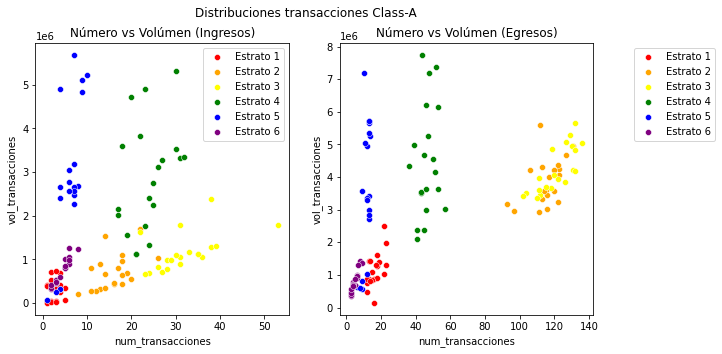

In [ ]:
figura, subFiguras = PyPlot.subplots(1,2, #vamos a poner un arreglo de 1x2 figuras
                                     figsize=(10,5)) #El tamaño va a ser de 12 x 3 unidades
colores ={'Estrato 1':'red',
          'Estrato 2':'orange',
          'Estrato 3':'yellow',
          'Estrato 4':'green',
          'Estrato 5':'blue',
          'Estrato 6':'purple'}
#ponemos el título grande
figura.suptitle('Distribuciones transacciones Class-A')
#ponemos los títulos para cada figura
subFiguras[0].set_title('Número vs Volúmen (Ingresos)')
subFiguras[1].set_title('Número vs Volúmen (Egresos)')
for i in range(0,len(estratos)):
  info_ingresos = info_estratos[estratos[i]]['ingresos']
  info_egresos = info_estratos[estratos[i]]['egresos']
  SeaBorn.scatterplot(data=info_ingresos,x='num_transacciones',y='vol_transacciones',ax=subFiguras[0],label=estratos[i],color=colores[estratos[i]])
  SeaBorn.scatterplot(data=info_egresos,x='num_transacciones',y='vol_transacciones',ax=subFiguras[1],label=estratos[i],color=colores[estratos[i]])
PyPlot.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
PyPlot.show()

# Usando pruebas estadísticas para caracterizar a los clientes

Desde las gráficas podemos ver que hay distintos comportamientos en materia de ingresos egresos y en volúmen para los clientes de diferentes estratos en el Banco Class-A. 

Notemos que cada día, un cliente de un estrato $e$ tiene una probabilidad $p_e^i$ de hacer un ingreso y una probabilidad $p_e^e$ de hacer un egreso. Como ambos eventos son complementarios (si no es un egreso, es un ingreso), debemos tener que 

>>>$p_e^i+p_e^e = 1$

Notemos que el ingresar dinero a la cuenta es una variable aleatoria tipo Binomial. De $N_e$ transacciones que realiza un estrato al mes, tiene $N_e^*$ eventos favorables (Ingresos).

In [ ]:
probabilidadesDeEgresos = Pandas.DataFrame(columns=['estrato','N','mu_egresos','p_egreso','desv_egreso'])

for estrato in info_estratos.keys():
  ingresos = info_estratos[estrato]['ingresos']
  egresos = info_estratos[estrato]['egresos']
  num_ingresos = ingresos['num_transacciones'].sum()
  num_egresos = egresos['num_transacciones'].sum()
  num_transac = num_ingresos + num_egresos
  p_egreso = num_egresos/(num_transac)
  std_ingreso = NumPy.sqrt(p_egreso*(1-p_egreso)/num_transac)
  probabilidadesDeEgresos = probabilidadesDeEgresos.append({'estrato':estrato,
                                                'N':num_transac,
                                                'mu_egresos':num_egresos,
                                                'p_egreso':p_egreso,
                                                'desv_egreso':std_ingreso},True)

probabilidadesDeEgresos

,estrato,N,mu_egresos,p_egreso,desv_egreso
0,Estrato 1,387,332,0.857881,0.017749
1,Estrato 2,2629,2311,0.879041,0.006360
2,Estrato 3,3056,2419,0.791558,0.007348
3,Estrato 4,1401,926,0.660956,0.012647
4,Estrato 5,348,228,0.655172,0.025479
5,Estrato 6,179,99,0.553073,0.037161


In [ ]:
probabilidadesDeEgresos

,estrato,N,mu_egresos,p_egreso,desv_egreso
0,Estrato 1,387,332,0.857881,0.017749
1,Estrato 2,2629,2311,0.879041,0.006360
2,Estrato 3,3056,2419,0.791558,0.007348
3,Estrato 4,1401,926,0.660956,0.012647
4,Estrato 5,348,228,0.655172,0.025479
5,Estrato 6,179,99,0.553073,0.037161


De forma análoga, notemos que el volúmen transaccionado por los clientes (en cada día de transacción) es una variable numérica, normalmente distribuida. Así, sus egresos por estrato
>>$E_e\sim N(\mu_e,\sigma_e)$

que podemos calcular usando un bloque similar al anterior. Aquí, notemos que esto es el volúmen medio transaccional mensual de los clientes de un estrato específico (esto es, el estrato hace estas transacciones). 

In [ ]:
volumenDeEgresos = Pandas.DataFrame(columns=['estrato','N','mu_egresos','desv_egreso'])

for estrato in info_estratos.keys():
  ingresos = info_estratos[estrato]['ingresos']
  egresos = info_estratos[estrato]['egresos']
  num_ingresos = ingresos['num_transacciones'].mean()
  num_egresos = egresos['num_transacciones'].mean()
  num_transac = num_ingresos + num_egresos
  mu_egreso = egresos['vol_transacciones'].mean()
  std_ingreso = egresos['vol_transacciones'].std()
  volumenDeEgresos = volumenDeEgresos.append({'estrato':estrato,
                                                'N':num_transac,
                                                'mu_egresos':mu_egreso,
                                                'desv_egreso':std_ingreso},True)

volumenDeEgresos

,estrato,N,mu_egresos,desv_egreso
0,Estrato 1,19.350000,1.148936e+06,5.186631e+05
1,Estrato 2,131.450000,3.878182e+06,7.151032e+05
2,Estrato 3,152.800000,4.232228e+06,7.150361e+05
3,Estrato 4,70.050000,4.494879e+06,1.700865e+06
4,Estrato 5,17.400000,3.534634e+06,2.038723e+06
5,Estrato 6,9.160526,8.093167e+05,3.119027e+05


Que podemos escribir formateado (más bonito) con el siguiente bloque

In [ ]:
for idx,row in volumenDeEgresos.iterrows():
  estrato = row['estrato']
  num_transacciones = row['N']
  media_egresos = row['mu_egresos']
  desv_egresos = row['desv_egreso']
  print(estrato,num_transacciones,"${:,.2f}".format(media_egresos),"${:,.2f}".format(desv_egresos))

Estrato 1 19.35 $1,148,936.33 $518,663.09
Estrato 2 131.45 $3,878,182.16 $715,103.16
Estrato 3 152.8 $4,232,228.42 $715,036.14
Estrato 4 70.05 $4,494,879.16 $1,700,864.57
Estrato 5 17.4 $3,534,634.04 $2,038,722.71
Estrato 6 9.160526315789474 $809,316.72 $311,902.70


Con esta información podemos averiguar qué clientes pertenecen a las distribuciones de su estrato. Vamos a consultar en la Base de Datos para saber cómo ha sido el comportamiento de los clientes en un mes. 

In [ ]:
query_transacciones_clientes = """SELECT egresos_clientes_estadisticos.cedula as "cedula",
       egresos_clientes_estadisticos.estrato as "estrato",
       transacciones_clientes_info.num_transacciones as "num_transacciones",
       egresos_clientes_estadisticos.num_egresos as "num_egresos",
       egresos_clientes_estadisticos.media_egresos as "media_egresos",
       egresos_clientes_estadisticos.desv_egresos AS "desv_egresos" 
FROM  transacciones_clientes_info JOIN egresos_clientes_estadisticos ON transacciones_clientes_info.cedula = egresos_clientes_estadisticos.cedula;
"""

Ahora consultamos con la base de datos 

In [ ]:
transacciones_clientes = busquedaComoDataFrame(query_transacciones_clientes)

conexión establecida con la base de datos
resultado obtenido, todo bien


Ahora, vamos a tomar una muestra aleatoria de 10 clientes. 

In [ ]:
muestra = transacciones_clientes.sample(10)
muestra

,cedula,estrato,num_transacciones,num_egresos,media_egresos,desv_egresos
177,1001651536,2,12,12,22078.473333,9181.630326
701,49646690,4,13,9,59961.142222,27177.903413
492,1002984207,1,5,2,13150.640000,4987.719102
612,45631874,3,7,7,28376.408571,24721.060512
881,79850263,3,8,8,24887.275000,12632.859512
572,45421878,2,3,3,27225.276667,23172.080154
800,79338186,2,6,5,32618.744000,9763.445675
747,79050260,3,7,7,30082.092857,7751.769585
488,1002969291,4,16,11,49042.617273,14537.920421
654,45973936,3,9,7,29586.382857,9767.574138


In [ ]:
from google.colab import files
muestra.to_csv('muestra.csv',sep=';',float_format ='%.2f',decimal=',')
files.download('muestra.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>